# Agente Conversacional con MCP Server para datos.gob.es

Construimos un sistema de IA de dos componentes para explorar el Catálogo de datos abiertos de España usando Google ADK y un servidor de herramientas desacoplado basado en el protocolo MCP (Model Context Protocol).

Como ejercicio práctico, crearemos un agente conversacional que permite explorar el Catálogo nacional de datos abiertos albergado en datos.gob.es mediante preguntas en lenguaje natural, facilitando así el acceso a datos públicos.

El objetivo es aprender, mediante un problema didáctico e ilustrativo, cuál es el fundamento de esta tecnología. Al completarlo, tendrás la base necesaria para crear tus propios servidores MCP.

## 0. Planteamiento del problema y configuración del entorno

### El Problema

El Catálogo nacional de datos abiertos de España (datos.gob.es) es un recurso inmenso que puede ser consultado mediante un sistema de búsqueda facetada y mecanismos de filtrado, y que cuenta con una API pública que puede ser compleja de consultar directamente sin conocimientos de programación. Los usuarios que busquen datasets de una forma más simple e intuitiva, podrían pensar en hacer preguntas en lenguaje natural y descubrir qué datos están disponibles.

### La Solución

Construimos un asistente de IA conversacional que actúa como un experto en el Catálogo de datos.gob.es.

Para lograr esto, utilizamos una arquitectura de microservicios desacoplada:

1. **Agente de IA**: Un agente (LlmAgent de Google ADK) que entiende el lenguaje natural. Se expone a través de una API FastAPI y puede ser consultado con una interfaz de chat en web.

2. **Servidor MCP (Backend)**: Un servidor MCP que define un conjunto de "herramientas" (tools) simples. Estas herramientas envuelven la lógica compleja de consultar la API de datos.gob.es y formatear los resultados.

El Agente de IA no sabe cómo buscar en la API de datos.gob.es, solo sabe que tiene herramientas (provistas por el Servidor MCP) que puede usar, como `buscar_datasets(titulo=...)`.

### Tecnologías Utilizadas

- **FastMCP**: implementación ligera del protocolo MCP para crear el servidor de herramientas de forma rápida y eficiente.
- **Google ADK** (Agent Development Kit): para definir el agente de IA, su prompt y sus herramientas.
- **FastAPI**: para servir el agente de IA como una API REST y una interfaz web.
- **httpx**: para realizar llamadas asíncronas a la API externa de datos.gob.es desde el servidor de herramientas.
- **Docker y Docker Compose**: para containerizar y orquestar los dos microservicios, permitiendo que se ejecuten y comuniquen de forma aislada.

### Arquitectura del Sistema
```
┌─────────────────────────────────────────────────────────────────────┐
│                            USUARIO                                   │
│                     (Navegador Web)                                  │
└────────────────────────────────┬────────────────────────────────────┘
                                 │
                                 │ HTTP Request
                                 │ "Busca datasets sobre clima"
                                 │
                                 ▼
┌─────────────────────────────────────────────────────────────────────┐
│                        AGENTE (Puerto 8080)                          │
│  ┌───────────────────────────────────────────────────────────────┐  │
│  │  Agent Development Kit (Google ADK)                           │  │
│  │  - LlmAgent con prompt de sistema                            │  │
│  │  - Interfaz web para chat                                    │  │
│  │  - FastAPI /docs para testing                                │  │
│  └───────────────────────────────────────────────────────────────┘  │
└────────────────────────────────┬────────────────────────────────────┘
                                 │
                                 │ Tool Call
                                 │ buscar_datasets(titulo="clima")
                                 │
                                 ▼
┌─────────────────────────────────────────────────────────────────────┐
│                   MCP SERVER (Puerto 8000)                           │
│  ┌───────────────────────────────────────────────────────────────┐  │
│  │  FastMCP - Servidor de Herramientas                          │  │
│  │  - buscar_datasets()                                         │  │
│  │  - listar_tematicas()                                        │  │
│  │  - obtener_detalle_dataset()                                 │  │
│  │  - buscar_por_tematica()                                     │  │
│  └───────────────────────────────────────────────────────────────┘  │
└────────────────────────────────┬────────────────────────────────────┘
                                 │
                                 │ HTTP GET/POST
                                 │ (httpx.AsyncClient)
                                 │
                                 ▼
┌─────────────────────────────────────────────────────────────────────┐
│              API EXTERNA: https://datos.gob.es/apidata              │
│                    (Catálogo Nacional de Datos Abiertos)             │
└─────────────────────────────────────────────────────────────────────┘
```

**Flujo de una solicitud:**

1. **Usuario** envía mensaje → `"Busca datasets sobre el clima"`.
2. **Agente ADK** recibe mensaje y analiza qué herramienta necesita.
3. **Agente** invoca `buscar_datasets(titulo="clima")` → llama al **MCP Server**.
4. **MCP Server** ejecuta la función → hace request a `datos.gob.es/apidata`.
5. **API externa** devuelve JSON complejo con resultados.
6. **MCP Server** limpia y formatea los datos → devuelve dict simple al Agente.
7. **Agente ADK** recibe los datos → formula respuesta en lenguaje natural.
8. **Usuario** ve la respuesta en la interfaz web.


## 1. Componente Core: El Servidor de Herramientas (MCP)

El corazón de la lógica de este ejercicio reside en `server.py`. Este archivo *no* contiene lógica de IA; su única responsabilidad es actuar como un **"adaptador"** robusto entre la API de `datos.gob.es` y el agente.

Define un conjunto de funciones Python simples y las expone como **"herramientas"** (tools) que cualquier servicio de IA (en nuestro caso, el agente ADK) puede consumir a través del protocolo MCP.

### ¿Qué es el Model Context Protocol (MCP)?

**MCP** es un protocolo estándar abierto que permite a los agentes de IA descubrir y usar herramientas externas de forma dinámica. Piensa en él como un "contrato" que define cómo los agentes y los servidores de herramientas se comunican entre sí.

**Analogía**: Si el agente de IA es como un asistente inteligente, MCP es el "manual de instrucciones" que le dice qué herramientas tiene disponibles (un martillo, un destornillador, una llave inglesa...) y cómo usarlas correctamente.

**Características clave de MCP**:
- **Descubrimiento automático**: el agente puede preguntar al servidor "¿qué herramientas tienes?" y obtener una lista con sus descripciones
- **Definición declarativa**: cada herramienta declara sus parámetros, tipos de datos y qué hace
- **Agnóstico al modelo**: funciona con cualquier modelo de IA (GPT, Claude, Gemini, etc.)
- **Basado en estándares web**: usa HTTP/JSON, lo que facilita la integración

En nuestro caso, usamos **FastMCP**, una implementación ligera del protocolo que nos permite crear un servidor de herramientas con muy poco código.


### ¿Por qué separar el servidor de herramientas del agente?

Esta arquitectura desacoplada ofrece múltiples ventajas:

- **Reutilización**: estas herramientas pueden ser consumidas por diferentes agentes o aplicaciones.
- **Mantenibilidad**: los cambios en la API externa solo afectan al servidor MCP.
- **Escalabilidad**: el servidor MCP puede escalarse independientemente del agente.
- **Testing**: es más fácil probar las herramientas de forma aislada.
- **Flexibilidad**: podemos cambiar el agente (usar Claude, GPT, etc.) sin tocar el servidor.

### Flujo de Operación del Servidor

1. Inicia un servidor `FastMCP` en el puerto 8000.
2. Registra varias funciones Python usando el decorador `@mcp.tool`.
3. Cada función decorada se convierte en un endpoint que el agente puede llamar
4. Dentro de cada función, se usa `httpx.AsyncClient` para hacer una llamada asíncrona a `https://datos.gob.es/apidata`.
5. Se procesa la respuesta JSON.
6. Se devuelve un diccionario Python simple y limpio al agente.

### Herramientas disponibles

El servidor expone **4 herramientas principales**:

1. **`buscar_datasets`**: busca datasets por palabras clave en el título.
2. **`listar_tematicas`**: obtiene todas las categorías temáticas disponibles.
3. **`obtener_detalle_dataset`**: obtiene información completa de un dataset específico.
4. **`buscar_por_tematica`**: busca datasets filtrados por categoría temática.

### 1.1 server.py - El Corazón de la Lógica de Datos

#### ¿Qué hace?
Este archivo define y ejecuta el servidor `FastMCP` que expone las herramientas para consultar `datos.gob.es`.

#### ¿Cómo funciona?
- **`mcp = FastMCP("datos.gob.es API")`**: Inicializa el servidor.
- **`@mcp.tool(...)`**: Este decorador mágico registra la función siguiente como una herramienta consumible. La `description` es crucial, ya que es lo que el LLM del agente leerá para saber *cuándo* usar esta herramienta.
- **`async def ...`**: Todas las herramientas son asíncronas para no bloquear el servidor, ya que dependen de llamadas de red (`httpx`).
- **`_get_multilang_value(...)`**: Una función de utilidad vital para navegar los campos JSON multilingües de la API, priorizando el español (`es`).
- **`mcp.run(...)`**: Inicia el servidor.

#### Detalles de Implementación
Observa cómo las funciones (ej. `buscar_datasets`) reciben `titulo: str` como argumento. `FastMCP` (basado en Pydantic) maneja automáticamente la validación de estos argumentos. Si el agente llama a la herramienta con un tipo de dato incorrecto, el servidor lo rechazará.

In [ ]:
%%writefile server.py
from mcp.server.fastmcp import FastMCP, Context
import httpx
from typing import Dict, List, Any
from pydantic import BaseModel, Field
import logging

mcp = FastMCP("datos.gob.es API")

BASE_URL = "https://datos.gob.es/apidata"

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


def _get_multilang_value(field: Any, default: str = "Sin valor") -> str:
    """
    Extrae un valor de un campo multilingüe de la API de datos.gob.es.
    Prioriza el idioma 'es'.
    """
    if not field:
        return default

    try:
        if isinstance(field, list) and field:
            for item in field:
                if isinstance(item, dict) and item.get('_lang') == 'es':
                    return str(item.get('_value', default))
            first_item = field[0]
            if isinstance(first_item, dict):
                return str(first_item.get('_value', default))
            return str(first_item)

        if isinstance(field, dict):
             return str(field.get('_value', default))

        return str(field)

    except Exception:
        return str(field)

@mcp.tool(description="Buscar datasets por título en datos.gob.es")
async def buscar_datasets(
    titulo: str = Field(description="Palabra o frase para buscar en el título"),
    ctx: Context = None
) -> Dict:
    """Busca datasets por título"""
    if ctx:
        await ctx.info(f"Buscando: {titulo}")

    try:
        url = f"{BASE_URL}/catalog/dataset/title/{titulo}.json"
        params = {"_pageSize": 5, "_page": 0}

        async with httpx.AsyncClient(timeout=30.0) as client:
            response = await client.get(url, params=params)
            response.raise_for_status()
            data = response.json()

        items = data.get("result", {}).get("items", [])
        total = data.get("result", {}).get("totalItems", 0)

        if not items:
            return {
                "exito": False,
                "mensaje": f"No se encontraron datasets con '{titulo}'",
                "total": 0,
                "datasets": []
            }

        datasets = []
        for item in items[:20]:
            titulo_val = _get_multilang_value(item.get("title"), "Sin título")
            desc_val = _get_multilang_value(item.get("description"), "Sin descripción")

            datasets.append({
                "titulo": titulo_val,
                "descripcion": desc_val[:150] + "...",
                "id": item.get("_about", "").split("/")[-1] if item.get("_about") else "sin-id"
            })

        return {
            "exito": True,
            "total": total,
            "mostrando": len(datasets),
            "datasets": datasets
        }

    except Exception as e:
        logger.error(f"Error: {str(e)}")
        return {
            "exito": False,
            "mensaje": f"Error al buscar: {str(e)}",
            "total": 0,
            "datasets": []
        }


@mcp.tool(description="Listar todas las temáticas disponibles")
async def listar_tematicas(ctx: Context = None) -> Dict:
    """Lista todas las temáticas del catálogo"""
    if ctx:
        await ctx.info("Obteniendo temáticas...")

    try:
        url = f"{BASE_URL}/catalog/theme.json"

        async with httpx.AsyncClient(timeout=30.0) as client:
            response = await client.get(url)
            response.raise_for_status()
            data = response.json()

        items = data.get("result", {}).get("items", [])

        if not items:
            return {
                "exito": False,
                "mensaje": "No se pudieron obtener las temáticas",
                "tematicas": []
            }

        tematicas = []
        for item_uri in items:
            if isinstance(item_uri, str):
                id_tematica = item_uri.split("/")[-1] if item_uri else "sin-id"
                nombre_tematica = id_tematica.replace("-", " ").capitalize()
            else:
                about = item_uri.get("_about", "")
                id_tematica = about.split("/")[-1] if about else "sin-id"
                nombre_tematica = _get_multilang_value(item_uri.get("label"), id_tematica)

            tematicas.append({
                "id": id_tematica,
                "nombre": nombre_tematica
            })

        return {
            "exito": True,
            "total": len(tematicas),
            "tematicas": tematicas
        }

    except Exception as e:
        logger.error(f"Error: {str(e)}")
        return {
            "exito": False,
            "mensaje": f"Error al listar temáticas: {str(e)}",
            "tematicas": []
        }


@mcp.tool(description="Buscar datasets de una temática específica")
async def buscar_por_tematica(
    tematica_id: str = Field(description="ID de la temática (ej: medio-ambiente, salud, economia)"),
    ctx: Context = None
) -> Dict:
    """Busca datasets de una temática"""
    if ctx:
        await ctx.info(f"Buscando en temática: {tematica_id}")

    try:
        url = f"{BASE_URL}/catalog/dataset/theme/{tematica_id}.json"
        params = {"_pageSize": 10, "_page": 0}

        async with httpx.AsyncClient(timeout=30.0) as client:
            response = await client.get(url, params=params)
            response.raise_for_status()
            data = response.json()

        items = data.get("result", {}).get("items", [])
        total = data.get("result", {}).get("totalItems", 0)

        if not items:
            return {
                "exito": False,
                "mensaje": f"No se encontraron datasets para la temática '{tematica_id}'",
                "total": 0,
                "datasets": []
            }

        datasets = []
        for item in items[:5]:
            titulo_val = _get_multilang_value(item.get("title"), "Sin título")
            desc_val = _get_multilang_value(item.get("description"), "Sin descripción")

            datasets.append({
                "titulo": titulo_val,
                "descripcion": desc_val[:250] + "..."
            })

        return {
            "exito": True,
            "tematica": tematica_id,
            "total": total,
            "mostrando": len(datasets),
            "datasets": datasets
        }

    except Exception as e:
        logger.error(f"Error: {str(e)}")
        return {
            "exito": False,
            "mensaje": f"Error al buscar por temática: {str(e)}",
            "total": 0,
            "datasets": []
        }


@mcp.tool(description="Obtener información detallada de un dataset específico por su ID")
async def obtener_detalles_dataset(
    dataset_id: str = Field(description="ID del dataset (ej: l01281230-calidad-del-aire)"),
    ctx: Context = None
) -> Dict:
    """
    Obtiene información completa y detallada de un dataset específico.
    Incluye: título, descripción completa, publisher, temáticas, distribuciones disponibles,
    formatos, URLs de descarga, fechas de creación/modificación, licencia, etc.
    """
    if ctx:
        await ctx.info(f"Obteniendo detalles del dataset: {dataset_id}")

    try:
        url = f"{BASE_URL}/catalog/dataset/{dataset_id}.json"

        async with httpx.AsyncClient(timeout=30.0) as client:
            response = await client.get(url)
            response.raise_for_status()
            data = response.json()

        items = data.get("result", {}).get("items", [])

        if not items:
            return {
                "exito": False,
                "mensaje": f"No se encontró el dataset con ID '{dataset_id}'",
                "dataset": None
            }

        item = items[0]

        titulo = _get_multilang_value(item.get("title"), "Sin título")
        descripcion = _get_multilang_value(item.get("description"), "Sin descripción")

        # Publisher/Organismo
        publisher_data = item.get("publisher", {})
        if isinstance(publisher_data, dict):
            publisher_name = _get_multilang_value(publisher_data.get("name"), "Desconocido")
        else:
            publisher_name = "Desconocido"

        # Temáticas
        temas = item.get("theme", [])
        tematicas = []
        if isinstance(temas, list):
            for tema in temas:
                if isinstance(tema, str):
                    tematicas.append(tema.split("/")[-1])
                elif isinstance(tema, dict):
                    tematicas.append(_get_multilang_value(tema.get("_about", ""), "").split("/")[-1])

        # Distribuciones (formatos disponibles)
        distribuciones_raw = item.get("distribution", [])
        distribuciones = []

        for dist in distribuciones_raw[:10]:
            if isinstance(dist, dict):
                formato = dist.get("format", {})
                if isinstance(formato, dict):
                    formato_str = _get_multilang_value(formato.get("value"), "Desconocido")
                else:
                    formato_str = str(formato) if formato else "Desconocido"

                titulo_dist = _get_multilang_value(dist.get("title"), "Sin título")
                access_url = dist.get("accessURL", "")
                byte_size = dist.get("byteSize", "")

                distribuciones.append({
                    "titulo": titulo_dist,
                    "formato": formato_str,
                    "url": access_url if isinstance(access_url, str) else "",
                    "tamaño": byte_size if byte_size else "Desconocido"
                })

        # Palabras clave
        keywords = item.get("keyword", [])
        palabras_clave = []
        if isinstance(keywords, list):
            for kw in keywords[:10]:  # Limitar a 10 keywords
                palabras_clave.append(_get_multilang_value(kw, ""))

        # Fechas
        fecha_creacion = item.get("issued", "")
        fecha_modificacion = item.get("modified", "")

        # Licencia
        licencia_data = item.get("license", {})
        if isinstance(licencia_data, dict):
            licencia = _get_multilang_value(licencia_data.get("_about", ""), "No especificada")
        else:
            licencia = str(licencia_data) if licencia_data else "No especificada"

        # Cobertura temporal
        cobertura_temporal = item.get("temporal", "")
        if isinstance(cobertura_temporal, dict):
            inicio = cobertura_temporal.get("startDate", "")
            fin = cobertura_temporal.get("endDate", "")
            cobertura_temporal_str = f"{inicio} - {fin}" if inicio or fin else "No especificada"
        else:
            cobertura_temporal_str = str(cobertura_temporal) if cobertura_temporal else "No especificada"

        # Cobertura espacial
        cobertura_espacial = item.get("spatial", [])
        coberturas_espaciales = []
        if isinstance(cobertura_espacial, list):
            for espacial in cobertura_espacial[:5]:
                if isinstance(espacial, str):
                    coberturas_espaciales.append(espacial.split("/")[-1])
                elif isinstance(espacial, dict):
                    coberturas_espaciales.append(espacial.get("_about", "").split("/")[-1])

        dataset_detalle = {
            "id": dataset_id,
            "titulo": titulo,
            "descripcion": descripcion,
            "publisher": publisher_name,
            "tematicas": tematicas if tematicas else ["Sin temática"],
            "palabras_clave": palabras_clave if palabras_clave else [],
            "fecha_creacion": fecha_creacion if fecha_creacion else "No disponible",
            "fecha_modificacion": fecha_modificacion if fecha_modificacion else "No disponible",
            "licencia": licencia,
            "cobertura_temporal": cobertura_temporal_str,
            "cobertura_espacial": coberturas_espaciales if coberturas_espaciales else ["No especificada"],
            "total_distribuciones": len(distribuciones_raw),
            "distribuciones": distribuciones,
            "url_catalogo": f"https://datos.gob.es/es/catalogo/{dataset_id}"
        }

        return {
            "exito": True,
            "dataset": dataset_detalle
        }

    except httpx.HTTPStatusError as e:
        logger.error(f"Error HTTP {e.response.status_code}: {str(e)}")
        return {
            "exito": False,
            "mensaje": f"Dataset no encontrado o error en la API (HTTP {e.response.status_code})",
            "dataset": None
        }
    except Exception as e:
        logger.error(f"Error: {str(e)}")
        return {
            "exito": False,
            "mensaje": f"Error al obtener detalles: {str(e)}",
            "dataset": None
        }


@mcp.tool(description="Obtener estadísticas generales del catálogo de datos.gob.es")
async def obtener_estadisticas_catalogo(ctx: Context = None) -> Dict:
    """
    Genera un resumen estadístico del catálogo completo de datos.gob.es.
    Incluye: total de datasets, total de distribuciones, formatos más comunes,
    temáticas con más datasets, y otros indicadores útiles.
    """
    if ctx:
        await ctx.info("Generando estadísticas del catálogo...")

    try:
        async with httpx.AsyncClient(timeout=60.0) as client:
            url_datasets = f"{BASE_URL}/catalog/dataset.json"
            response_datasets = await client.get(url_datasets, params={"_pageSize": 1, "_page": 0})
            response_datasets.raise_for_status()
            data_datasets = response_datasets.json()
            total_datasets = data_datasets.get("result", {}).get("totalItems", 0)

            url_distributions = f"{BASE_URL}/catalog/distribution.json"
            response_distributions = await client.get(url_distributions, params={"_pageSize": 1, "_page": 0})
            response_distributions.raise_for_status()
            data_distributions = response_distributions.json()
            total_distribuciones = data_distributions.get("result", {}).get("totalItems", 0)

            url_themes = f"{BASE_URL}/catalog/theme.json"
            response_themes = await client.get(url_themes)
            response_themes.raise_for_status()
            data_themes = response_themes.json()
            tematicas_items = data_themes.get("result", {}).get("items", [])
            total_tematicas = len(tematicas_items)

            url_publishers = f"{BASE_URL}/catalog/publisher.json"
            response_publishers = await client.get(url_publishers, params={"_pageSize": 1, "_page": 0})
            response_publishers.raise_for_status()
            data_publishers = response_publishers.json()
            total_publishers = data_publishers.get("result", {}).get("totalItems", 0)

            formatos_count = {}
            url_dist_sample = f"{BASE_URL}/catalog/distribution.json"
            response_dist_sample = await client.get(url_dist_sample, params={"_pageSize": 200, "_page": 0})
            response_dist_sample.raise_for_status()
            data_dist_sample = response_dist_sample.json()
            dist_items = data_dist_sample.get("result", {}).get("items", [])

            for dist in dist_items:
                formato = dist.get("format", "")
                if isinstance(formato, dict):
                    formato_str = _get_multilang_value(formato.get("value"), "Desconocido")
                else:
                    formato_str = str(formato) if formato else "Desconocido"

                formato_str = formato_str.lower().strip()
                if formato_str and formato_str != "desconocido":
                    formatos_count[formato_str] = formatos_count.get(formato_str, 0) + 1

            top_formatos = sorted(formatos_count.items(), key=lambda x: x[1], reverse=True)[:10]

            promedio_distribuciones_por_dataset = round(total_distribuciones / total_datasets, 2) if total_datasets > 0 else 0
            promedio_datasets_por_publisher = round(total_datasets / total_publishers, 2) if total_publishers > 0 else 0

            tematicas_count = {}
            url_datasets_sample = f"{BASE_URL}/catalog/dataset.json"
            response_datasets_sample = await client.get(url_datasets_sample, params={"_pageSize": 100, "_page": 0})
            response_datasets_sample.raise_for_status()
            data_datasets_sample = response_datasets_sample.json()
            datasets_items = data_datasets_sample.get("result", {}).get("items", [])

            for dataset in datasets_items:
                themes = dataset.get("theme", [])
                if isinstance(themes, list):
                    for theme in themes:
                        if isinstance(theme, str):
                            theme_id = theme.split("/")[-1]
                        elif isinstance(theme, dict):
                            theme_id = theme.get("_about", "").split("/")[-1]
                        else:
                            continue

                        if theme_id:
                            tematicas_count[theme_id] = tematicas_count.get(theme_id, 0) + 1

            top_tematicas = sorted(tematicas_count.items(), key=lambda x: x[1], reverse=True)[:10]

            estadisticas = {
                "total_datasets": total_datasets,
                "total_distribuciones": total_distribuciones,
                "total_tematicas": total_tematicas,
                "total_publishers": total_publishers,
                "promedio_distribuciones_por_dataset": promedio_distribuciones_por_dataset,
                "promedio_datasets_por_publisher": promedio_datasets_por_publisher,
                "formatos_mas_comunes": [
                    {"formato": fmt, "cantidad": cnt} for fmt, cnt in top_formatos
                ],
                "tematicas_mas_populares": [
                    {"tematica": tema.replace("-", " ").title(), "cantidad_datasets": cnt}
                    for tema, cnt in top_tematicas
                ],
                "nota": "Las estadísticas de formatos y temáticas se basan en una muestra representativa del catálogo"
            }

            return {
                "exito": True,
                "estadisticas": estadisticas
            }

    except Exception as e:
        logger.error(f"Error al generar estadísticas: {str(e)}")
        return {
            "exito": False,
            "mensaje": f"Error al generar estadísticas: {str(e)}",
            "estadisticas": None
        }

mcp.settings.host = "0.0.0.0"

if __name__ == "__main__":
    mcp.run(transport="streamable-http")

Writing server.py


### 1.2 Análisis de las Herramientas (Tools)

El archivo `server.py` define las siguientes capacidades para el agente:

- **`buscar_datasets(titulo: str)`**:
    - **Descripción:** "Buscar datasets por título en datos.gob.es"
    - **Lógica:** llama a la API `/catalog/dataset/title/{titulo}.json`. Devuelve una lista de datasets que coinciden, con su título, descripción e ID.

- **`listar_tematicas()`**:
    - **Descripción:** "Listar todas las temáticas disponibles"
    - **Lógica:** llama a `/catalog/theme.json`. Devuelve una lista de todas las temáticas (ej. "salud", "economia") con sus IDs.

- **`buscar_por_tematica(tematica_id: str)`**:
    - **Descripción:** "Buscar datasets de una temática específica"
    - **Lógica:** llama a `/catalog/dataset/theme/{tematica_id}.json`. Devuelve los datasets más relevantes para esa temática.

- **`obtener_detalles_dataset(dataset_id: str)`**:
    - **Descripción:** "Obtener información detallada de un dataset específico por su ID"
    - **Lógica:** llama a `/catalog/dataset/{dataset_id}.json`. Esta es la herramienta más compleja; extrae título, descripción, publicador, temáticas, formatos, URLs de descarga, fechas, licencia, etc.

- **`obtener_estadisticas_catalogo()`**:
    - **Descripción:** "Obtener estadísticas generales del catálogo de datos.gob.es"
    - **Lógica:** realiza múltiples llamadas a la API para obtener totales (datasets, distribuciones, publishers) y estadísticas de muestra (formatos, temáticas populares).

## 2. Componente Core: El Agente Conversacional (Google ADK)

Este es el componente "frontal" del sistema. Su trabajo es entender al usuario y usar las herramientas (provistas por el `MCP Server`) para construir una respuesta.

Está compuesto por dos archivos principales:
1.  **`agent.py`**: define la personalidad, instrucciones y herramientas del agente.
2.  **`main.py`**: carga el agente y lo sirve al mundo exterior usando `FastAPI`.


### 2.1 agent.py - El Cerebro del Asistente

#### ¿Qué hace?
Define la instancia `LlmAgent` que es el núcleo de nuestro asistente.

#### ¿Cómo funciona?
- **`root_agent = LlmAgent(...)`**: Creamos el agente.
- **`name="datos_agent"`**: Importante, este nombre debe coincidir con el de la carpeta (`datos_agent/`) para que el cargador de `google-adk` lo encuentre.
- **`model=GEMINI_MODEL`**: Especifica qué modelo de IA usar (en este caso, Gemini Flash).
- **`instruction="..."`**: Este es el **prompt del sistema**. Es la instrucción más importante que le dice al agente *cómo* comportarse, cuál es su trabajo y cómo debe usar sus herramientas.

#### Integración (La Clave del Proyecto)
La parte más crítica es el argumento `tools`:
```python
    tools=[
        MCPToolset(
            connection_params=StreamableHTTPConnectionParams(
                url=FASTMCP_SERVER_URL, # "http://mcp-server:8000/mcp"
            ),
        )
    ]
```
Esto le dice al agente: "Tus herramientas no están definidas aquí en el código Python. Para saber qué herramientas tienes, ve y consulta esta URL: http://mcp-server:8000/mcp".

El MCP Server (que creamos con server.py) responderá en esa URL con la lista de herramientas, sus descripciones y sus argumentos. Este desacoplamiento es poderoso: podemos actualizar las herramientas en server.py sin tener que redesplegar el agente.

In [ ]:
%mkdir datos_agent

In [ ]:
%%writefile datos_agent/agent.py
import os
from google.adk.agents import LlmAgent
from google.adk.tools.mcp_tool.mcp_toolset import MCPToolset, StreamableHTTPConnectionParams


FASTMCP_SERVER_URL = "http://mcp-server:8000/mcp"
GEMINI_MODEL = os.getenv("GEMINI_MODEL", "gemini-3-flash-preview")

# Agente principal que consulta datos.gob.es
root_agent = LlmAgent(
    name="datos_agent",  # Este nombre debe coincidir con el nombre de la carpeta que contiene el archivo siempre
    model=GEMINI_MODEL,
    instruction="""Eres un asistente especializado en ayudar a usuarios a explorar y descubrir conjuntos de datos 
    del catálogo nacional de datos abiertos de España (datos.gob.es).

    Tu trabajo es:
    1. Ayudar a los usuarios a buscar datasets según sus necesidades
    2. Proporcionar información clara y estructurada sobre los datasets encontrados
    3. Sugerir temáticas relevantes cuando sea apropiado
    4. Explicar qué contiene cada dataset de forma accesible

    Cuando el usuario pregunte por datos sobre algún tema:
    - Primero intenta buscar datasets con palabras clave relevantes
    - Si hay muchos resultados, menciona cuántos hay en total
    - Presenta los resultados más relevantes de forma clara
    - Si conoces el ID exacto de un dataset, puedes obtener más detalles específicos

    Siempre sé amable, claro y directo. Si no encuentras resultados, sugiere términos de búsqueda alternativos
    o temáticas relacionadas que puedan ser útiles.
    """,
    description="Asistente para explorar el catálogo de datos abiertos de España",
    tools=[
        MCPToolset(
            connection_params=StreamableHTTPConnectionParams(
                url=FASTMCP_SERVER_URL,
            ),
        )
    ]
)

Writing datos_agent/agent.py


### 2.2 main.py - El Punto de Entrada de la API

#### ¿Qué hace?
Este archivo es el "lanzador" del servicio del agente. Utiliza `google-adk` para crear una aplicación `FastAPI` que sirva a todos los agentes encontrados en el directorio.

#### ¿Cómo funciona?
- **`AGENT_DIR = ...`**: le dice al cargador que busque agentes en el directorio actual.
- **`SESSION_SERVICE_URI = "sqlite:///:memory:"`**: configura el manejo de sesiones de chat. `sqlite:///:memory:` es una base de datos temporal en memoria, ideal para desarrollo y demos. Para producción, se cambiaría a un archivo (`sqlite:///./sessions.db`) o una base de datos persistente.
- **`ALLOWED_ORIGINS = ["*"]`**: configuración de CORS. `*` permite conexiones desde cualquier origen, lo cual es inseguro para producción pero útil para el desarrollo y demos.
- **`SERVE_WEB_INTERFACE = True`**: una característica muy útil de `google-adk`. Genera automáticamente una interfaz web de chat simple en la raíz (`/`) de la API. Utilizaremos esta interfaz para demostrar el comportamiento del sistema.
- **`app: FastAPI = get_fast_api_app(...)`**: esta es la función principal de ADK que escanea `AGENT_DIR`, encuentra `datos_agent` (gracias a `__init__.py`), y construye todos los endpoints de FastAPI necesarios para chatear con él.
- **`@app.get("/health")`**: un endpoint de salud personalizado para verificar que el servicio está vivo.
- **`uvicorn.run(app, ...)`**: inicia el servidor FastAPI si el script se ejecuta directamente.

In [ ]:
%%writefile main.py
import os
import uvicorn
from fastapi import FastAPI
from google.adk.cli.fast_api import get_fast_api_app


AGENT_DIR = os.path.dirname(os.path.abspath(__file__))
SESSION_SERVICE_URI = "sqlite:///./sessions.db"
# Configuración para GitHub Codespaces y localhost
ALLOWED_ORIGINS = [
    "http://localhost",
    "http://localhost:8080",
    "https://*.app.github.dev",  # Permite todas las URLs de Codespaces
    "*"  # Permite todos los orígenes (útil para desarrollo)
]
SERVE_WEB_INTERFACE = True

app: FastAPI = get_fast_api_app(
    agents_dir=AGENT_DIR,
    session_service_uri=SESSION_SERVICE_URI,
    allow_origins=ALLOWED_ORIGINS,
    web=SERVE_WEB_INTERFACE,
)

@app.get("/health")
async def health_check():
    return {"status": "healthy", "service": "datos-gob-agent"}

if __name__ == "__main__":
    uvicorn.run(app, host="0.0.0.0", port=8080)

Writing main.py


## 3. Archivos de Configuración y Soporte

Estos archivos conectan todo el proyecto, definen dependencias y configuran el entorno.

### 3.1 requirements.txt - Dependencias del Proyecto

#### ¿Qué hace?
Lista todas las bibliotecas de Python necesarias para *ambos* servicios.

#### Contenido
- **`google-adk`**: el kit de desarrollo de agentes, necesario para `agent.py` y `main.py`.
- **`fastapi`**: el framework web, usado por `google-adk` en `main.py` y por `mcp.server.fastmcp` en `server.py`.
- **`uvicorn`**: el servidor ASGI que ejecuta las aplicaciones FastAPI.
- **`pydantic` y `pydantic-settings`**: usados para la validación de datos, tanto por FastAPI como por `mcp.server`.
- **`httpx`**: el cliente HTTP asíncrono, esencial en `server.py` para llamar a la API externa.

In [ ]:
%%writefile requirements.txt
# Dependencias del proyecto

google-adk
fastapi
uvicorn
pydantic<2.12
pydantic-settings
httpx
mcp<1.20.0

Overwriting requirements.txt


### 3.2 .env - Variables de Entorno

#### ¿Qué hace?
Almacena secretos y configuraciones que no deben estar en el código.

#### Contenido
- **`GOOGLE_API_KEY`**: La clave de API para los servicios de IA de Google (como el modelo Gemini). Esta clave es leída por el `LlmAgent` en `agent.py`.
- **IMPORTANTE:** El archivo `.env` proporcionado tiene una clave de ejemplo. Deberás reemplazarla con tu propia clave de API de Google válida para que el agente funcione.

In [ ]:
%%writefile .env
GOOGLE_API_KEY="CLAVE_DE_EJEMPLO"

# Puedes usar "gemini-3-flash-preview" o cualquiera de los modelos disponibles en tu cuenta de Google (https://aistudio.google.com/api-keys)
GEMINI_MODEL="gemini-3-flash-preview"

Overwriting .env


### 3.3 datos_agent/__init__.py - Paquete del Agente

#### ¿Qué hace?
Este archivo (que puede estar vacío o no) tiene dos propósitos:
1.  Le dice a Python que el directorio `datos_agent/` debe ser tratado como un "paquete".
2.  El cargador de `google-adk` (`get_fast_api_app` en `main.py`) busca este archivo para identificar los directorios que contienen agentes.
3.  Al importar y exponer `root_agent` en `__all__`, facilita que el cargador de ADK lo encuentre.

In [ ]:
%%writefile datos_agent/__init__.py
from .agent import root_agent

__all__ = ["root_agent"]

Writing datos_agent/__init__.py


## 4. Despliegue con Docker y Docker Compose

Esta es una parte crucial del proyecto. Dado que tenemos dos servicios separados que deben ejecutarse y comunicarse, `Docker Compose` es la herramienta ideal para orquestarlos.

### Estructura de Contenedores
- **`mcp-server`**: un contenedor que ejecuta `server.py`.
- **`fastapi-app`**: un contenedor que ejecuta `main.py`.
- **`app-network`**: una red virtual privada que permite a `fastapi-app` encontrar a `mcp-server` usando su nombre de servicio (ej. `http://mcp-server:8000`).

### 4.1 Docker Compose - Orquestando los microservicios

#### ¿Qué hace?
`docker-compose.yml` es el archivo de configuración que define y orquesta nuestros dos servicios (agente y MCP server), permitiéndoles comunicarse entre sí.

#### ¿Cómo funciona?
Docker Compose se encarga de:
- **Construir** las imágenes de ambos servicios usando sus respectivos Dockerfiles
- **Crear una red privada** (`datos-network`) donde ambos contenedores pueden comunicarse
- **Inyectar variables de entorno** desde el archivo `.env`
- **Exponer puertos** al host para acceder a los servicios
- **Gestionar el ciclo de vida** de ambos contenedores simultáneamente

#### Detalles de Implementación

**Red privada**: los servicios se comunican usando nombres DNS internos. El agente puede llamar a `http://mcp-server:8000` porque Docker Compose resuelve automáticamente el nombre del servicio.

**Puertos expuestos**:
- `8000:8000` → MCP Server (para inspección y debugging)
- `8080:8080` → Agente con interfaz web (puerto principal de acceso)

**Variables de entorno**: la clave `GOOGLE_API_KEY` se carga desde el archivo `.env` y se inyecta en el contenedor del agente.



In [ ]:
%%writefile docker-compose.yml
services:
  mcp-server:
    build:
      context: .
      dockerfile: Dockerfile.mcp
    container_name: datos-gob-mcp-server
    ports:
      - "8000:8000"
    networks:
      - app-network


  fastapi-app:
    build:
      context: .
      dockerfile: Dockerfile.app
    container_name: datos-gob-agent
    ports:
      - "8080:8080"
    env_file:
      - .env
    networks:
      - app-network

networks:
  app-network:
    driver: bridge

Writing docker-compose.yml


### 4.2 Dockerfile.app - Containerizando el Agente

#### ¿Qué hace?
Define la "receta" para construir la imagen de Docker del servicio del agente.

#### ¿Cómo funciona?
- **`FROM python:3.12-slim`**: Usa una imagen base ligera de Python.
- **`WORKDIR /app`**: Establece el directorio de trabajo dentro del contenedor.
- **`RUN apt-get ... gcc`**: Instala `gcc`, un compilador de C que a veces es necesario para instalar dependencias de Python.
- **`COPY requirements.txt .` y `RUN pip install ...`**: Copia solo `requirements.txt` primero. Docker almacenará en caché este paso. Si no cambiamos las dependencias, no se volverá a ejecutar, haciendo las builds futuras más rápidas.
- **`COPY datos_agent/ ./datos_agent/` y `COPY main.py .`**: Copia el código fuente de la aplicación.
- **`EXPOSE 8080`**: Informa a Docker que la aplicación usará este puerto.
- **`CMD ["python", "main.py"]`**: El comando que se ejecuta cuando se inicia el contenedor.

In [ ]:
%%writefile Dockerfile.app
FROM python:3.12-slim

WORKDIR /app

# Instalar dependencias del sistema
RUN apt-get update && apt-get install -y \
    gcc \
    && rm -rf /var/lib/apt/lists/*

# Copiar requirements y instalar dependencias
COPY requirements.txt .
RUN pip install --no-cache-dir -r requirements.txt

# Copiar el código del agente y main.py
COPY datos_agent/ ./datos_agent/
COPY main.py .

# Exponer puerto
EXPOSE 8080

# Comando para ejecutar FastAPI
CMD ["python", "main.py"]

Writing Dockerfile.app


### 4.3 Dockerfile.mcp - Containerizando el Servidor de Herramientas

#### ¿Qué hace?
Define la receta para construir la imagen de Docker del servicio MCP.

#### ¿Cómo funciona?
Es casi idéntico al `Dockerfile.app`, lo cual es bueno (consistencia). La única diferencia clave es qué código copia y qué comando ejecuta al final:
- **`COPY server.py .`**: copia el código del servidor de herramientas.
- **`EXPOSE 8000`**: expone el puerto 8000.
- **`CMD ["python", "server.py"]`**: ejecuta el servidor MCP.

In [ ]:
%%writefile Dockerfile.mcp
FROM python:3.12-slim

WORKDIR /app

# Instalar dependencias del sistema necesarias
RUN apt-get update && apt-get install -y \
    gcc \
    && rm -rf /var/lib/apt/lists/*

# Copiar requirements y instalar dependencias
COPY requirements.txt .
RUN pip install --no-cache-dir -r requirements.txt

# Copiar el servidor MCP
COPY server.py .

# Exponer puerto
EXPOSE 8000

# Comando para ejecutar el servidor
CMD ["python", "server.py"]

Writing Dockerfile.mcp


## 5. Ejecución del proyecto

### Requisitos Previos
1. **Docker** y **Docker Compose** instalados
   - En local: Docker Desktop (Windows/Mac) o Docker Engine (Linux)
   - En [GitHub Codespaces](https://codespaces.new/Admindatosgobes/Laboratorio-de-Datos): Sin instalación necesaria, ya viene preconfigurado.
   - Verifica con: `docker --version` y `docker-compose --version`
2. **Clave de API de Google** válida para usar Gemini
   - Obtén tu clave gratuita en: https://aistudio.google.com/app/apikey

### Opción 1: Ejecución en Local (tu máquina)

#### 1. Preparar el entorno
Asegúrate de tener todos los archivos del proyecto en un solo directorio:
```
proyecto/
├── datos_agent/
│   └── agent.py
│   └── __init__.py
├── server.py
├── main.py
├── requirements.txt
├── Dockerfile.app
├── Dockerfile.mcp
├── docker-compose.yml
└── .env
```

#### 2. Construir y ejecutar los contenedores
Abre una terminal en el directorio raíz del proyecto y ejecuta:
```bash
# Construir imágenes y levantar servicios
docker-compose up --build
```

**Explicación del comando**:
- `docker-compose up`: Inicia los servicios definidos en `docker-compose.yml`
- `--build`: Fuerza la reconstrucción de las imágenes (necesario la primera vez o tras cambios en el código)

**Nota**: La primera vez tardará unos minutos en descargar las imágenes base y construir los contenedores.

#### 3. Verificar que los servicios están corriendo

Verás logs de ambos servicios en la terminal. Busca mensajes como:
```
mcp-server    | INFO:     Application startup complete.
fastapi-app   | INFO:     Uvicorn running on http://0.0.0.0:8080
```
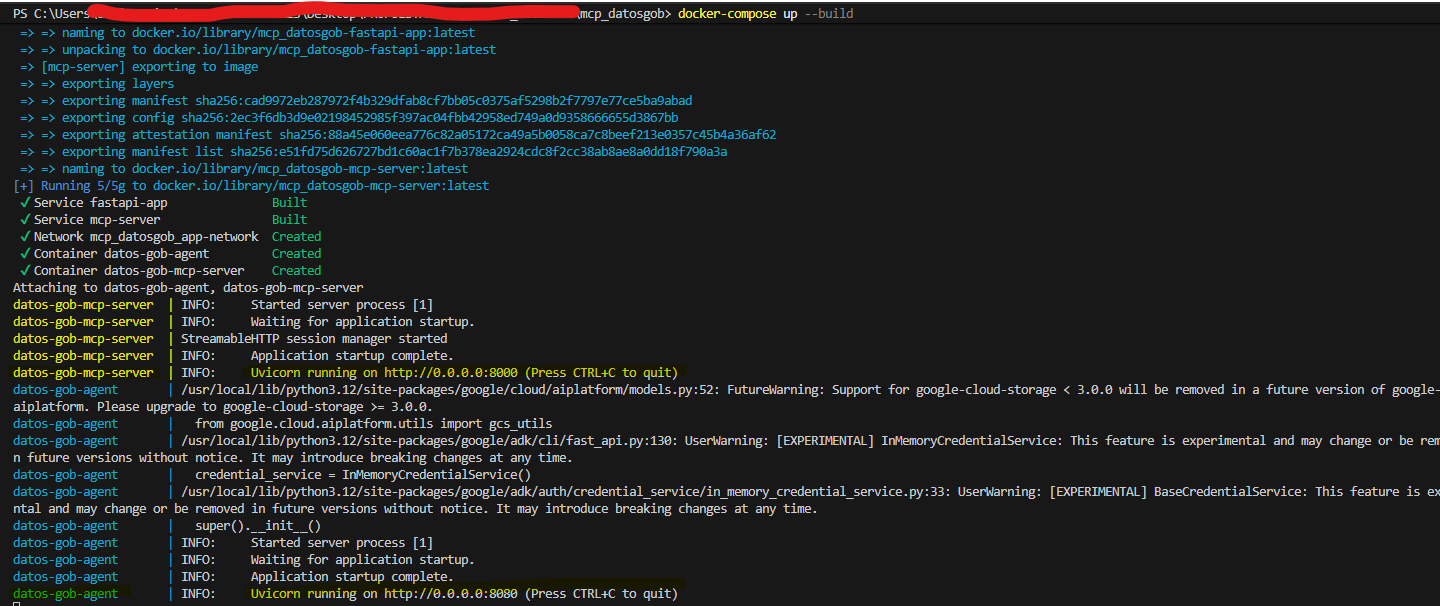

#### 4. Acceder a la interfaz web
Abre tu navegador y visita: **http://localhost:8080**

---

### Opción 2: Ejecución en GitHub Codespaces (en la nube)

**¿Qué es GitHub Codespaces?**  
Es un entorno de desarrollo completo en la nube con VS Code, terminal, Docker y todas las herramientas necesarias, accesible desde tu navegador.

[![Open in GitHub Codespaces](https://github.com/codespaces/badge.svg)](https://codespaces.new/Admindatosgobes/Laboratorio-de-Datos)

#### 1. Preparar el entorno
Los archivos ya están en tu Codespace. Navega al directorio del proyecto:
```bash
cd "Data Science/Agente Conversacional con MCP server"
```

#### 2. Construir y ejecutar los contenedores
Usa exactamente los mismos comandos que en local:
```bash
# Construir imágenes y levantar servicios en segundo plano
docker compose up -d --build
```

**Nota**: Usamos `-d` (detached) para que los contenedores corran en segundo plano y no bloqueen la terminal.

#### 3. Verificar que los servicios están corriendo
```bash
# Ver estado de los contenedores
docker ps

# Ver logs del agente
docker logs datos-gob-agent

# Ver logs del servidor MCP
docker logs datos-gob-mcp-server
```

Deberías ver que ambos contenedores están en estado `Up`.

#### 4. Acceder a la interfaz web en Codespaces

Cuando los contenedores estén ejecutándose, GitHub Codespaces detectará automáticamente que el puerto 8080 está en uso:

1. Verás una **notificación emergente** con un botón "Abrir en el navegador" - haz clic ahí, o
2. Ve a la pestaña **"PORTS"** en el panel inferior de VS Code
3. Busca el puerto **8080** en la lista
4. Haz clic en el icono de **globo** 🌐 junto al puerto, o haz clic derecho y selecciona "Abrir en el navegador"

La URL tendrá un formato similar a:
```
https://[nombre-tu-codespace]-8080.app.github.dev
```

Por ejemplo: `https://legendary-fiesta-9g7645gqr653xpgg-8080.app.github.dev`

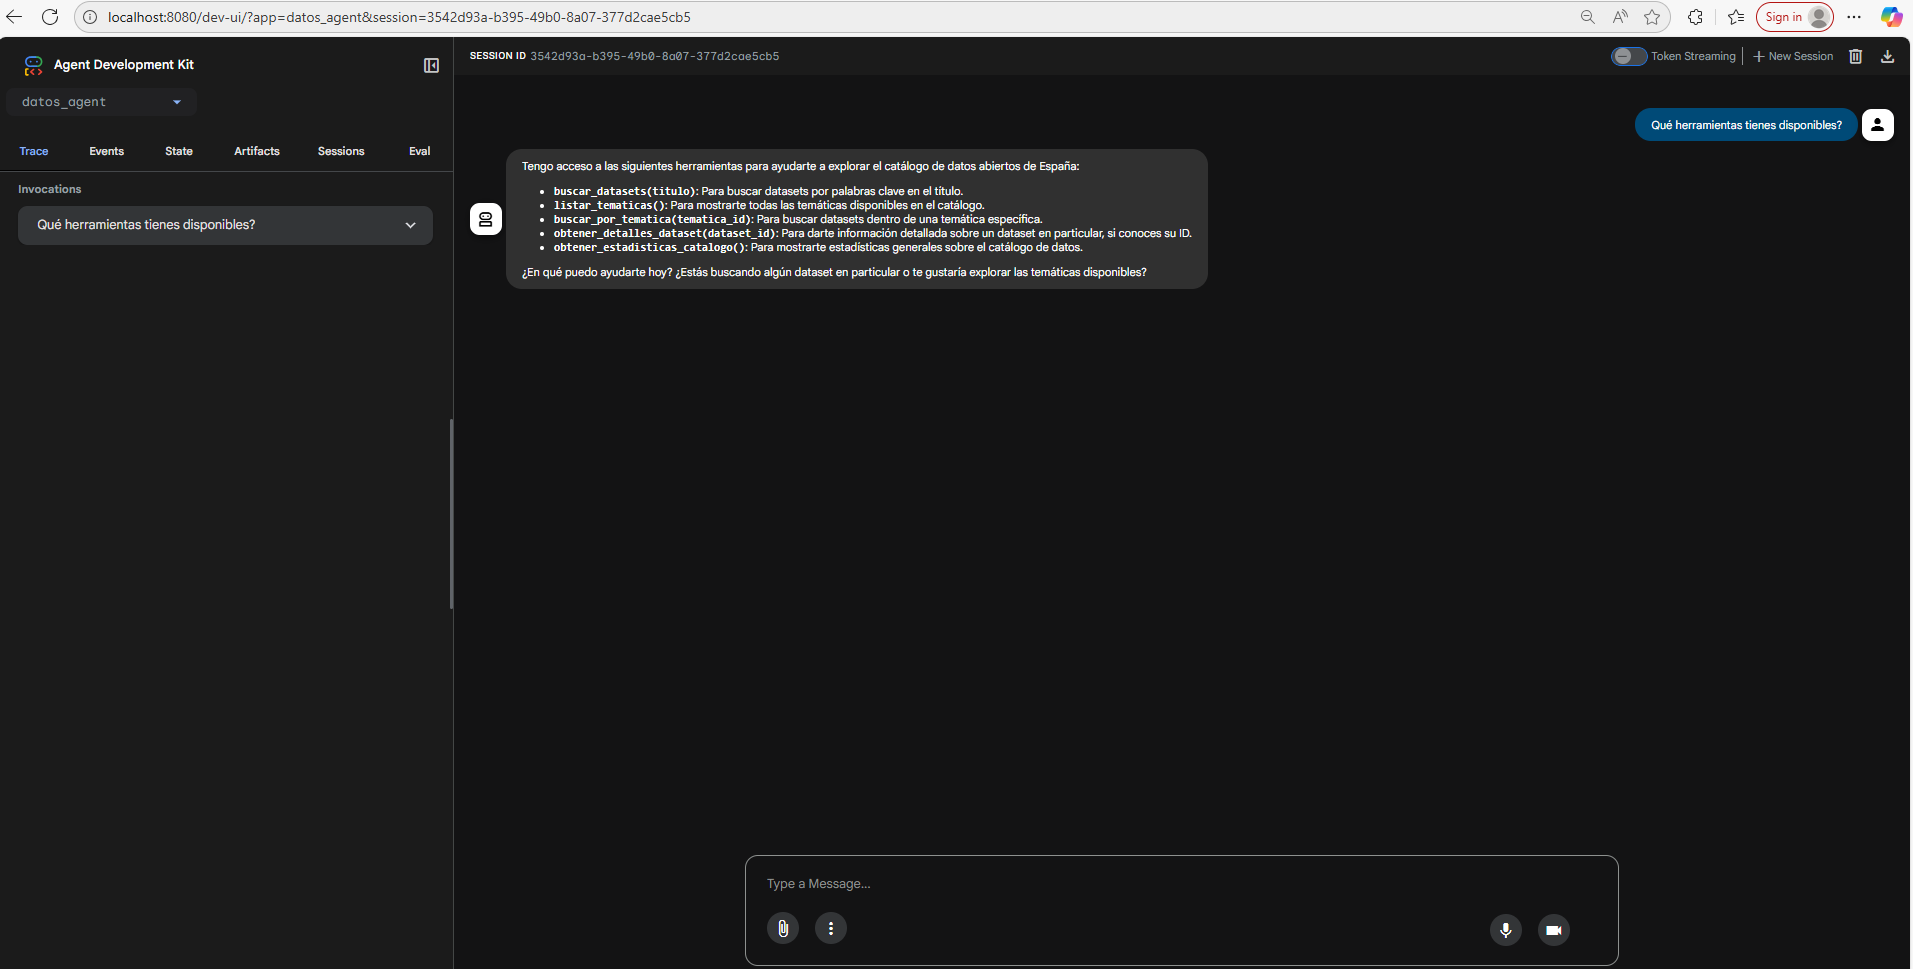

#### 5. Diferencias importantes entre Local y Codespaces

| Aspecto | Local | Codespaces |
|---------|-------|-----------|
| **URL de acceso** | `http://localhost:8080` | `https://[tu-codespace]-8080.app.github.dev` |
| **Protocolo** | HTTP | HTTPS (seguro) |
| **Docker** | Debes instalarlo | Ya viene instalado |
| **Acceso** | Solo desde tu máquina | Desde cualquier lugar con internet |
| **Comando docker-compose** | `docker-compose up --build` | `docker compose up -d --build` |
| **CORS** | Configurado para localhost | Configurado para `*.app.github.dev` |

**Ventajas de Codespaces**:
- No necesitas instalar nada en tu máquina
- Puedes compartir fácilmente la URL con otros (si configuras el puerto como público)
- Mismo entorno de desarrollo en cualquier ordenador
- Recursos de computación de GitHub (no consume tu CPU/RAM)

#### 6. Detener los contenedores (ambos entornos)

Cuando termines de trabajar:

**En local** (si ejecutaste sin `-d`):
```bash
# Presiona Ctrl+C en la terminal, luego:
docker-compose down
```

**En Codespaces** (o local con `-d`):
```bash
docker compose down
```

Esto detendrá y eliminará los contenedores, pero mantendrá las imágenes construidas para la próxima vez.

### Ejemplos de Uso en la Interfaz Web

Una vez que tengas la interfaz web del agente abierta en `http://localhost:8080`, puedes interactuar con él de forma natural. A continuación, mostramos ejemplos reales de consultas y las respuestas del agente.

#### Ejemplo 1: Explorando capacidades y buscando por temática

En este primer ejemplo, exploramos qué puede hacer el agente y cómo buscar datasets por categoría temática:

**Consultas realizadas**:
1. `"¿Qué herramientas tienes disponibles?"`
   - El agente responde listando todas sus herramientas: `buscar_datasets()`, `listar_tematicas()`, `buscar_por_tematica()`, `obtener_detalles_dataset()`, y `obtener_estadisticas_catalogo()`

2. `"¿Qué categorías o temáticas de datos están disponibles?"`
   - El agente invoca **`listar_tematicas()`**
   - Responde con las temáticas disponibles: *Envi* (medio ambiente), *Ac* (economía), *sociedad-bienestar*, *empleo*, *urbanismo-infraestructuras*, *sector-publico*, *Hb* (demografía).

3. `"Busca datasets sobre medio ambiente"`
   - El agente usa **`buscar_por_tematica()`** con la temática "medio-ambiente"
   - Devuelve 5 datasets relacionados, incluyendo:
     - Mapas estratégicos de Ruido.
     - Tratamiento de residuos (INE).
     - Rangos de Hábitat (periodo 2013-2018).
     - Distribución de Especies.
     - Avisos meteorológicos.

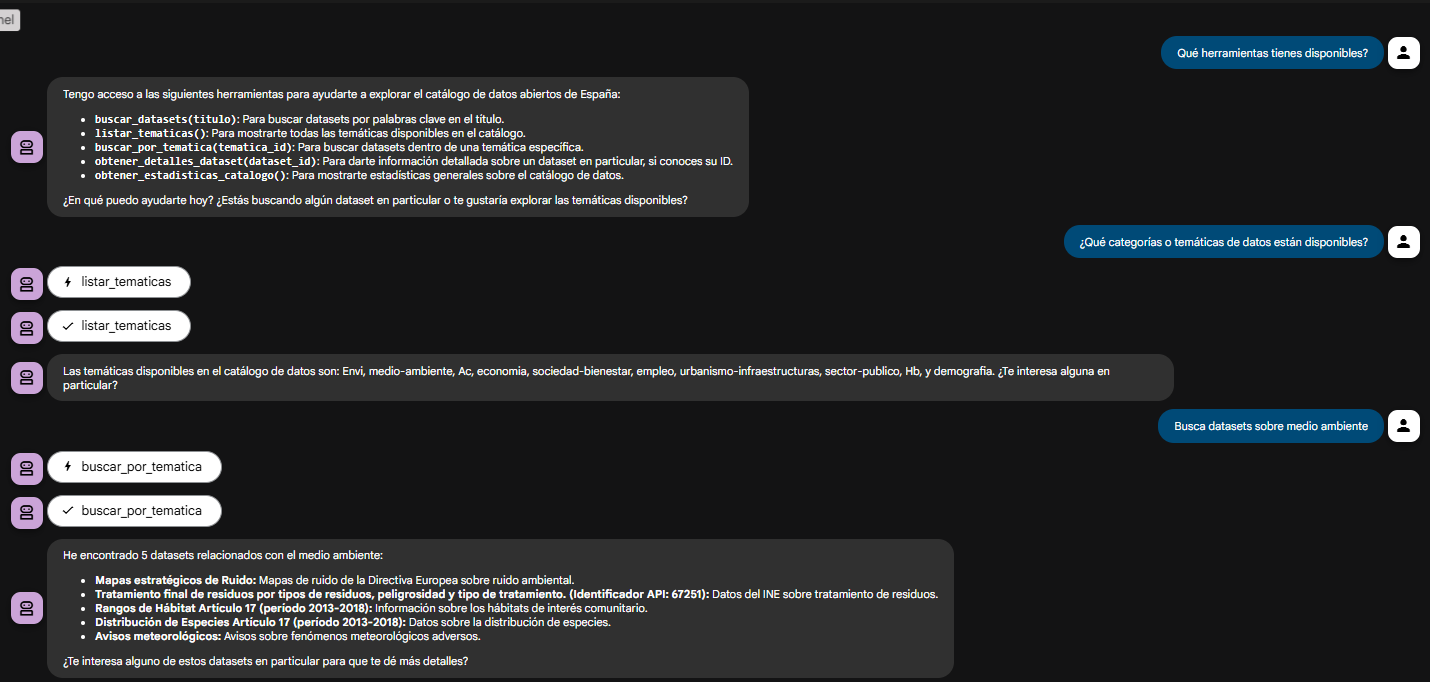

**Observaciones**:
- El agente **encadena herramientas** de forma inteligente: primero lista temáticas, luego busca dentro de la categoría específica.
- Muestra los **tool calls** en tiempo real (iconos de rayo ⚡).
- Formatea la respuesta en lenguaje natural, a pesar de recibir JSON complejo del servidor MCP.

---

#### Ejemplo 2: Búsquedas específicas y consultas encadenadas

En este segundo ejemplo, realizamos búsquedas más específicas y consultas que requieren múltiples pasos:

**Consultas realizadas**:
1. `"Necesito datos sobre calidad del aire"`
   - El agente usa **`buscar_datasets(titulo="calidad del aire")`**
   - Encuentra 5 datasets relevantes sobre calidad del aire en Castilla-La Mancha y Madrid:
     - Calidad del aire en Castilla-La Mancha (ID: `a08002880-calidad-del-aire-en-castilla-la-mancha`).
     - Red de Calidad del Aire - Datos del día en curso.
     - Red de Calidad del Aire - Datos del mes en curso.
     - Red de Calidad del Aire - Datos horarios desde 2005.
     - Red de Calidad del Aire - Datos meteorológicos del mes en curso.

2. `"Busca datasets sobre transporte y dame los detalles del primero que encuentres"`
   - El agente realiza **dos tool calls encadenados**:
     1. Primero: **`buscar_datasets(titulo="transporte")`**
     2. Segundo: **`obtener_detalles_dataset()`** con el ID del primer resultado
   - Devuelve información detallada del dataset "Viajes, pernoctaciones y gasto total por principal medio de transporte":
     - **Descripción**: tabla de INEbase con datos de la Encuesta de Turismo de Residentes.
     - **ID**: `ea0010587-viajes-pernoctaciones-y-gasto-total-por-principal-medio-de-transporte-etr-identificador-api-68552`.

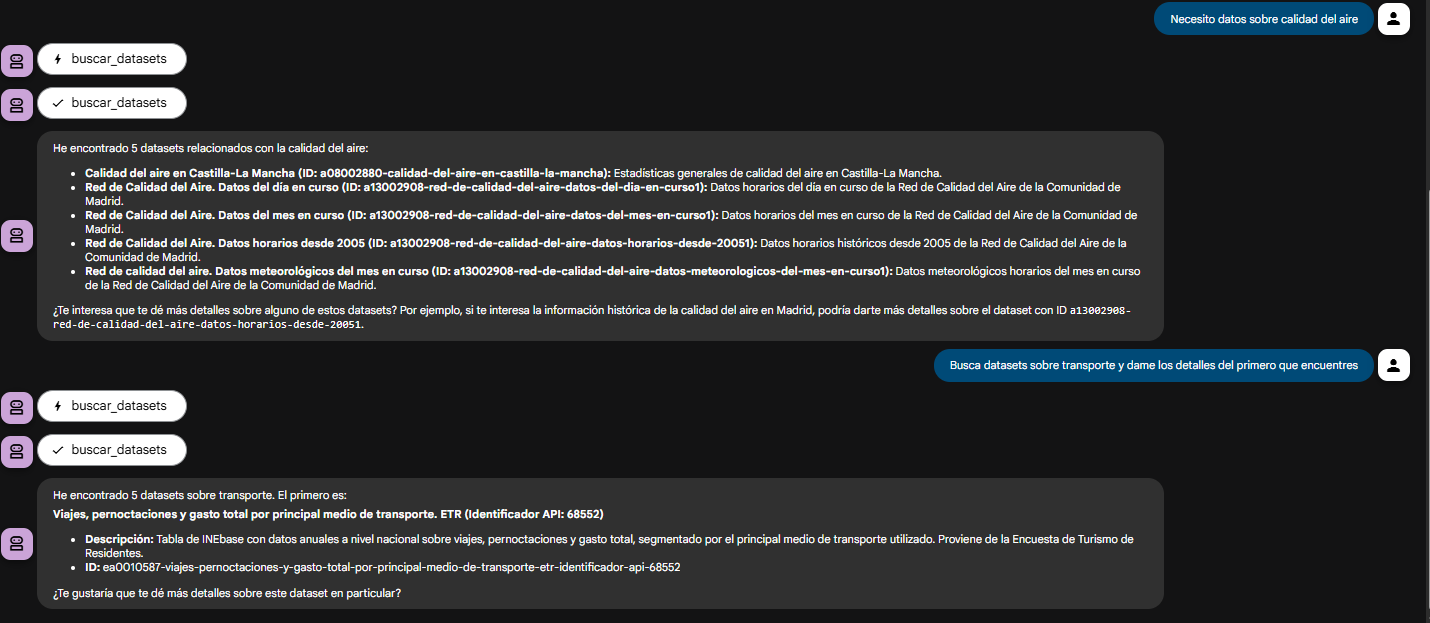

**Observaciones**:
- El agente entiende **intención compleja**: "busca X y dame detalles de Y".
- Ejecuta **múltiples tool calls en secuencia** sin intervención del usuario.
- Extrae y presenta la información más relevante de forma estructurada.

---

### ¿Qué observar en la interfaz?

Cuando interactúes con el agente, podrás ver:

1. **Mensajes del usuario**: tus consultas en lenguaje natural (lado derecho, azul).
2. **Respuestas del agente**: texto formateado y estructurado (lado izquierdo, gris).
3. **Tool calls en tiempo real**: iconos de rayo (⚡) que muestran qué herramienta está invocando el agente.
4. **Confirmación de ejecución**: checks (✓) que indican que la herramienta se ejecutó correctamente.
5. **Razonamiento**: el agente puede ofrecer seguir conversando o pedir más detalles.




## 6. Aplicación práctica y conclusiones

### Lo que hemos aprendido

En este notebook hemos explorado la implementación completa de un sistema de agente conversacional de IA con arquitectura desacoplada. Los conceptos técnicos clave que hemos cubierto incluyen:

- **Arquitectura de Agentes Desacoplada**: hemos implementado un patrón donde el "cerebro" del agente (Google ADK) está completamente separado de sus "manos" (el servidor MCP). Esta separación de responsabilidades hace que el sistema sea más mantenible, escalable y testeable.

- **Protocolo MCP (Model Context Protocol)**: hemos usado `mcp.server.fastmcp` para definir herramientas de forma declarativa y exponerlas a través de una API REST. Este protocolo permite que cualquier agente de IA pueda descubrir y usar nuestras herramientas sin conocer su implementación interna.

- **Google Agent Development Kit (`google-adk`)**: hemos utilizado `LlmAgent` para crear un agente conversacional completo, con capacidad de usar herramientas externas mediante `MCPToolset`, que conecta dinámicamente con nuestro servidor MCP.

- **Orquestación con Docker Compose**: hemos configurado un entorno de microservicios completo, incluyendo redes privadas, inyección de variables de entorno, y gestión del ciclo de vida de múltiples contenedores.

- **Programación Asíncrona**: hemos implementado operaciones I/O no bloqueantes usando `httpx.AsyncClient` y `async/await` para maximizar el rendimiento al interactuar con APIs externas.

- **Integración de APIs Externas**: hemos envuelto la API pública de `datos.gob.es` en una capa de abstracción limpia, procesando respuestas JSON complejas y multilingües en estructuras de datos simples.

### Casos de uso prácticos

Este tipo de arquitectura puede aplicarse en múltiples escenarios reales:

#### Periodismo de Datos
**Escenario**: Un periodista necesita encontrar rápidamente estadísticas gubernamentales para un artículo sobre medio ambiente.

**Con el agente**: pregunta en lenguaje natural *"Busca datasets sobre calidad del aire y dame los más recientes"* y obtiene resultados filtrados en segundos.

**Sin el agente**: tendría que navegar manualmente el portal de datos.gob.es, entender la estructura de la API, construir queries HTTP, procesar JSON complejo, y filtrar resultados relevantes.

#### Investigación Académica
**Escenario**: Un estudiante de doctorado necesita datos históricos sobre demografía española para su tesis.

**Con el agente**: puede mantener una conversación iterativa: *"Lista las temáticas disponibles"*, *"Busca datasets de demografía"*, *"Dame detalles del dataset X"*, refinando su búsqueda conversacionalmente.

**Valor añadido**: el agente actúa como un asistente de investigación que entiende contexto y puede sugerir datasets relacionados.

#### Transparencia y Gobierno Abierto
**Escenario**: una ONG de transparencia quiere monitorear automáticamente nuevos datasets de contratación pública.

**Con esta arquitectura**: pueden extender el servidor MCP con herramientas adicionales (webhooks, notificaciones, análisis automático) sin tocar el agente, y crear workflows automatizados.

#### Consultoría y Business Intelligence
**Escenario**: una consultora necesita datos económicos y de empleo para un proyecto de análisis sectorial.

**Con el agente**: centraliza búsquedas en el catálogo nacional y puede cruzar información de múltiples datasets mediante consultas encadenadas como *"Busca datasets de empleo por sectores y luego dame estadísticas del sector tecnológico"*.

### Ventajas de esta arquitectura

**Accesibilidad**: democratiza el acceso a datos abiertos mediante lenguaje natural, eliminando barreras técnicas

**Eficiencia**: reduce el tiempo de búsqueda y exploración de horas a minutos.

**Precisión**: el agente entiende contexto, intención y puede refinar búsquedas automáticamente.

**Escalabilidad**: se pueden añadir más herramientas al servidor MCP sin modificar el agente.

**Mantenibilidad**: la lógica de negocio (herramientas) está desacoplada del modelo de IA.

**Flexibilidad**: podemos cambiar el modelo de IA (de Gemini a Claude, GPT, etc.) sin tocar el servidor de herramientas.

**Reutilización**: otros agentes o aplicaciones pueden consumir las mismas herramientas MCP.

### Posibles extensiones

Este proyecto es una base sólida que puede extenderse de múltiples formas:

#### Mejoras al Servidor MCP
- **Caché inteligente**: añadir Redis para cachear llamadas a `listar_tematicas()` y búsquedas frecuentes, reduciendo latencia y carga en la API externa.
- **Más herramientas**: implementar filtros avanzados (por formato de archivo, por publicador, por fecha de actualización, por licencia).
- **Paginación**: añadir parámetros `limit` y `offset` en las búsquedas para manejar catálogos grandes.
- **Herramienta de descarga**: permitir al agente descargar directamente los datasets en diferentes formatos.
- **Estadísticas avanzadas**: añadir análisis de tendencias, datasets más populares, actualizaciones recientes.

#### Mejoras al Agente
- **Persistencia de sesiones**: cambiar `SESSION_SERVICE_URI` de `mem://` a `sqlite:///./sessions.db` para guardar conversaciones entre reinicios.
- **Multi-idioma**: se podría añadir traducción automática para usuarios internacionales.
- **Proactividad**: el agente podría sugerir datasets relacionados basándose en el historial de consultas.

#### Mejoras de Infraestructura
- **Autenticación y autorización**: añadir OAuth2 o API keys para proteger el acceso al agente.
- **Rate limiting**: implementar límites de peticiones para evitar abuso del servicio.
- **Logging y monitoreo**: integrar Prometheus + Grafana para observabilidad del sistema.
- **CI/CD**: configurar GitHub Actions para testing automático y despliegue continuo.
- **Despliegue en la nube**: adaptar para AWS ECS, Google Cloud Run, o Kubernetes.


### Recursos adicionales

- [Google Agent Development Kit (ADK)](https://google.github.io/adk-docs/) - Framework para crear agentes de IA
- [FastAPI](https://fastapi.tiangolo.com/) - Framework web moderno para Python
- [FastMCP](https://github.com/jlowin/fastmcp) - Implementación rápida del Model Context Protocol
- [Docker Compose](https://docs.docker.com/compose/) - Orquestación de contenedores




